In [1]:
from fastai.vision.all import *
set_seed(42)

from fastcore.parallel import *
from fastai.data.core import *
import torch
import time

In [2]:
import pandas as pd
from pathlib import Path

path = Path("/kaggle/input/isic-2024-challenge/")

# Construct the full path to the train file
train_metadata_path = path / 'train-metadata.csv'
images_path= Path('/kaggle/input/isic-2024-challenge/train-image/image/')

In [3]:
df = pd.read_csv(path/'train-metadata.csv')
df['isic_id'] = [name + '.jpg' for name in df['isic_id']]
df = df.set_index('isic_id')

# Calculate class weights for unbalanced data
class_counts = df['target'].value_counts().sort_index()
class_weights = class_counts.sum() / (len(class_counts) * class_counts)
class_weights = torch.tensor(class_weights.values, dtype=torch.float32)

 

/tmp/ipykernel_34/2611860256.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path/'train-metadata.csv')


In [4]:
#later we can try to include diagnosis as well
#def get_diagnosis(p): return df.loc[p.name, 'iddx_full']

def get_target(p): return df.loc[p.name, 'target']

In [5]:
%time
dls = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    n_inp=1,
    get_items=get_image_files,
    get_y = [get_target],
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(192, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
).dataloaders(images_path,num_workers=4)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


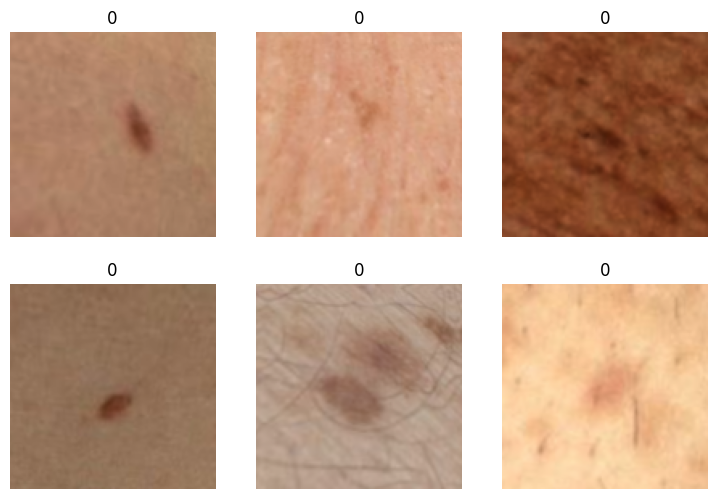

In [ ]:
dls.show_batch(max_n=6)

In [10]:
def target_err(inp,target): return error_rate(inp,target)
#def target_loss(inp,target): return F.cross_entropy(inp,target,weight=class_weights)
def target_loss(inp, target): 
    device = inp.device  # Get the device from input tensor
    current_class_weights = class_weights.to(device)  # Move class weights to the same device
    return F.cross_entropy(inp, target, weight=current_class_weights)

In [13]:
arch = 'convnext_small_in22k' 
#learn = vision_learner(dls, arch, loss_func=target_loss, metrics=target_err, n_out=7).to_fp16()
lr = 0.01

# Custom loss function with class weights on the correct device
def target_loss(inp, target): 
    device = inp.device  # Get the device from input tensor
    current_class_weights = class_weights.to(device)  # Move class weights to the same device
    return F.cross_entropy(inp, target, weight=current_class_weights)

# Create the learner
learn = vision_learner(dls, arch, loss_func=target_loss, metrics=target_err,n_out=2).to_fp16()

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

In [14]:
learn.fine_tune(1, lr)

epoch,train_loss,valid_loss,target_err,time
0,2.647075,1.380386,0.001907,16:32


epoch,train_loss,valid_loss,target_err,time
0,0.308515,0.350794,0.001845,21:58


In [15]:
#Save the trained model, for some reason I couldn't find the file in Kaggle output 
learn.export('/kaggle/working/my_model.pkl')
# for some reason I couldn't find this file in Kaggle output
print('Exported')

Exported


# Test part


In [16]:
ROOT_DIR = "/kaggle/input/isic-2024-challenge"
TEST_HDF = f'{ROOT_DIR}/test-image.hdf5'
TEST_CSV = f'{ROOT_DIR}/sample_submission.csv'

df_test = pd.read_csv(TEST_CSV)

In [17]:
import h5py
import numpy as np
from PIL import Image
from io import BytesIO
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class ISICDataset(Dataset):
    def __init__(self, df, file_hdf, transforms=None, target_size=(192,192)):
        self.df = df
        self.fp_hdf = h5py.File(file_hdf, mode="r")
        self.isic_ids = df['isic_id'].values
        self.targets = df['target'].values
        self.transforms = transforms
        self.target_size = target_size
        
    def __len__(self):
        return len(self.isic_ids)
    
    def __getitem__(self, index):
        isic_id = self.isic_ids[index]
        img = Image.open(BytesIO(self.fp_hdf[isic_id][()]))

        # Resize the image
        img = img.resize(self.target_size, Image.LANCZOS)

        # Convert to tensor if transforms are provided
        if self.transforms:
            img = self.transforms(img)

        return img, self.targets[index]
    
    def __getitem__(self, index):
        isic_id = self.isic_ids[index]
        img = Image.open(BytesIO(self.fp_hdf[isic_id][()]))

        # Resize the image
        img = img.resize(self.target_size, Image.LANCZOS)

        # Convert to tensor if transforms are provided
        if self.transforms:
            img = self.transforms(img)

        # Ensure target is of type Long
        target = torch.tensor(self.targets[index], dtype=torch.long)

        return img, target

# Define any transformations if needed
data_transforms = {
    'train_testing': T.Compose([
        T.Resize((192, 192)),  # Ensure images are resized
        T.ToTensor(),  # Convert image to tensor
    ])
}

# Define your configuration
CONFIG = {
    'valid_batch_size': 32
}



In [18]:
# Load your test data
test_dataset = ISICDataset(df_test, TEST_HDF, transforms=data_transforms['train_testing'])
 
test_loader = DataLoader(test_dataset, batch_size=CONFIG['valid_batch_size'], 
                          num_workers=4, shuffle=False, pin_memory=True)
 
 

In [19]:
# Set the model to evaluation mode
learn.model.eval()

# Run predictions on the test DataLoader
preds, targs = learn.get_preds(dl=test_loader)

In [20]:
import torch.nn.functional as F

#Initialize lists to collect predictions and ids
all_probs_class_1 = []
all_isic_ids = []

# Iterate over DataLoader
with torch.no_grad():
    for imgs, targets in test_loader:
        # Forward pass to get logits
        logits  = learn.get_preds(dl=test_loader)[0]
        
        # Apply softmax to get probabilities
        probabilities = F.softmax(logits, dim=1)
        
        # Extract the probabilities for class ID 1
        prob_class_1 = probabilities[:, 1].detach().cpu().numpy()
        
        # Collect the probabilities and ids
        all_probs_class_1.extend(prob_class_1)
        all_isic_ids.extend(test_dataset.isic_ids[:len(prob_class_1)])  # Adjust slicing as needed

In [21]:
# Create DataFrame
submission_df = pd.DataFrame({
    'isic_id': all_isic_ids,
    'prob_class_1': all_probs_class_1
})

# Save DataFrame to CSV
submission_df.to_csv('submission.csv', index=False)

 

In [22]:
submission_df

,isic_id,prob_class_1
0,ISIC_0015657,1.0
1,ISIC_0015729,1.0
2,ISIC_0015740,1.0
